In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [4]:
import itertools 

In [5]:
import dolphindb
sess = dolphindb.session()
sess.connect("localhost", 8868, "admin", "123456")
print('DolphinDB available tables:')
sess.run('getClusterDFSTables()')

True

DolphinDB available tables:


array(['dfs://dailyETF/dailyETF', 'dfs://dailyOptions/dailyOptionsBasic',
       'dfs://dailyStock/dailyStockBasic',
       'dfs://dailyStock/dailyStockCapitalReduction',
       'dfs://dailyStock/dailyStockCompanies',
       'dfs://dailyStock/dailyStockDealers',
       'dfs://dailyStock/dailyStockForeign',
       'dfs://dailyStock/dailyStockForeignShare',
       'dfs://dailyStock/dailyStockMargin',
       'dfs://dailyStock/dailyStockRightDividend',
       'dfs://dailyStock/dailyStockRightDividendComp',
       'dfs://dailyStock/dailyStockShortSale',
       'dfs://dailyStock/dailyStockShortSaleBalance',
       'dfs://dailyStock/dailyStockShortSaleVolume',
       'dfs://dailyStock/dailyStockTradeDay',
       'dfs://daily_stock/dailyStock',
       'dfs://daily_stock_margin/dailyStockMargin',
       'dfs://daily_tfe/tickTFE', 'dfs://feature/indicator',
       'dfs://futTaifex/futTaifex',
       'dfs://test_indicator_tfe/testIndicator'], dtype='<U44')

In [6]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pylab as plt

In [7]:
import config as cfg

In [20]:
#TODO: switch to ddb twse index 
twse = pd.read_msgpack('/data/dataset/twse.msgpack')
twse.head()

/home/cyyen/miniconda3/envs/stock_path_tracker/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3343: FutureWarning: The read_msgpack is deprecated and will be removed in a future version.
It is recommended to use pyarrow for on-the-wire transmission of pandas objects.
  exec(code_obj, self.user_global_ns, self.user_ns)


,open,high,low,close,order_buy,order_sell,volume
date,,,,,,,
2005-07-11,6255.40,6305.61,6249.41,6298.86,88271.0,98780.0,93877.0
2005-07-12,6337.50,6365.76,6337.50,6358.81,86565.0,111912.0,101703.0
2005-07-13,6360.60,6406.99,6352.21,6377.09,80802.0,120531.0,106134.0
2005-07-14,6403.08,6427.32,6375.75,6418.35,92496.0,114781.0,106806.0
2005-07-15,6428.44,6454.33,6410.59,6410.59,88827.0,124306.0,106727.0


# quantization: 2012-11-22 ~ 2020-04-15
- TODO: add maturity dates before December 2012
- size of cell: 100 
- rounding: take floor

In [21]:
df = twse[cfg.D_START:][['close']].copy()

In [22]:
df['prc_qtz'] = df.close // cfg.SIZE_CELL * cfg.SIZE_CELL
df['delta'] = df.prc_qtz.diff()

In [23]:
settlements = pd.to_datetime(pd.read_csv('settlement_txf.csv').settlement).dt.date.tolist()
df['maturity'] = df.index.where(df.index.isin(settlements)).to_series().fillna(method='bfill').values
d2m = df.groupby('maturity').size().sort_index().tolist()
df['d2m'] = sum([list(reversed(range(d))) for d in d2m], []) + [np.nan] * (df.shape[0] - sum(d2m))
df = df[cfg.D_START: cfg.D_END]

df.dropna(inplace=True)
df.sort_index(ascending=True, inplace=True)

## example: 2015-07-01 ~ 2015-07-14

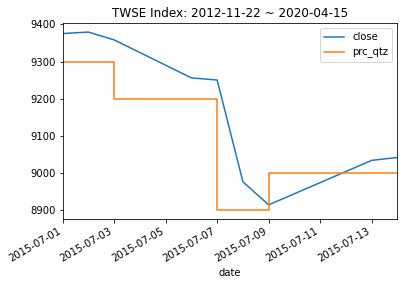

In [25]:
# vis
df_plot = df['2015-07-01': '2015-07-14' ]
ax = df_plot[['close']].plot(title=f'TWSE Index: {cfg.D_START} ~ {cfg.D_END}')
df_plot[['prc_qtz']].plot(drawstyle='steps', ax=ax)

# Distribution of changes in cell

## histogram 

Text(0.5, 1.0, '#(cells)')

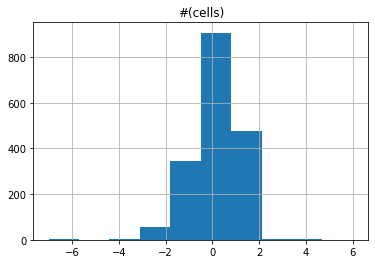

In [26]:
ax = df.delta.div(cfg.SIZE_CELL).hist()
ax.set_title('#(cells)')

## quantile

In [27]:
df_quantile = df.delta.div(cfg.SIZE_CELL).quantile([0, 0.025, 0.25, 0.5, 0.75, 0.975, 1]).to_frame('delta').T
df_quantile.columns = ['min', "2.5%", '25%', 'median', '75%', '97.5%', 'max']
df_quantile

,min,2.5%,25%,median,75%,97.5%,max
delta,-7.0,-2.0,0.0,0.0,1.0,1.0,6.0


## extreme cases

In [28]:
df_extreme_pos = df.query(f'(delta > 2*{cfg.SIZE_CELL})')
df_extreme_pos.sort_index()

,close,prc_qtz,delta,maturity,d2m
date,,,,,
2018-02-21,10714.44,10700.0,300.0,2018-02-21,0.0
2018-10-31,9802.13,9800.0,300.0,2018-11-21,15.0
2018-12-03,10137.87,10100.0,300.0,2018-12-19,12.0
2020-03-20,9234.09,9200.0,600.0,2020-04-15,16.0
2020-03-24,9285.62,9200.0,400.0,2020-04-15,14.0
2020-03-25,9644.75,9600.0,400.0,2020-04-15,13.0
2020-04-14,10332.94,10300.0,300.0,2020-04-15,1.0


In [29]:
df_extreme_neg = df.query(f'(delta < -2*{cfg.SIZE_CELL})')
df_extreme_neg.sort_index()

,close,prc_qtz,delta,maturity,d2m
date,,,,,
2015-07-08,8976.11,8900.0,-300.0,2015-07-15,4.0
2015-08-21,7786.92,7700.0,-300.0,2015-09-16,18.0
2015-08-24,7410.34,7400.0,-300.0,2015-09-16,17.0
2016-11-09,8943.20,8900.0,-300.0,2016-11-16,5.0
2018-02-06,10404.00,10400.0,-500.0,2018-02-21,5.0
2018-10-11,9806.11,9800.0,-600.0,2018-10-17,4.0
2018-12-06,9684.72,9600.0,-300.0,2018-12-19,9.0
2020-01-30,11421.74,11400.0,-700.0,2020-02-19,14.0
2020-03-09,10977.64,10900.0,-400.0,2020-03-18,7.0


# compute joint probabilty

- currently only calcualte for $\tau \leq 9$, because of huge computing demand and memory

# Cost distribution
- $OptPrc_t$: the settlePrice of t-1

# Profit

# Optimization

In [9]:
from optimize import *

In [7]:
df = get_df()
prob_delta_cell = get_prob_single_day(df)
df_cost = get_cost(df, cfg.CUTOFF_COST)

<ipython-input-7-f52f42a393ce>:1: FutureWarning: The read_msgpack is deprecated and will be removed in a future version.
It is recommended to use pyarrow for on-the-wire transmission of pandas objects.
  df = get_df()


In [10]:
var_lambda, var_tau = 2, 8
optimize(var_lambda, var_tau, df_cost, prob_delta_cell)

62.5 28.0


-21.55715387930067

# try brute force

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import matplotlib.pylab as plt
from matplotlib.ticker import MaxNLocator

In [3]:
from optimize import *
import config as cfg

In [24]:
n_tau = 10
n_lambd = 10
cutoff_cost = cfg.CUTOFF_COST

In [5]:
df = get_df()

<ipython-input-5-5b195cbacb59>:1: FutureWarning: The read_msgpack is deprecated and will be removed in a future version.
It is recommended to use pyarrow for on-the-wire transmission of pandas objects.
  df = get_df()


In [29]:
PROB = np.zeros((n_tau, n_lambd))
prob_delta_cell = get_prob_single_day(df)
for var_tau in range(n_tau):
    for var_lambda in range(n_lambd):
        PROB[var_tau, var_lambda] = get_realizations(var_lambda, var_tau).pipe(get_prob, prob_delta_cell)

In [25]:
PROFIT = np.array([cal_profit(var_lambda) for var_lambda in range(n_lambd)]).reshape(1, n_lambd)

In [26]:
df_cost = get_cost(df, cutoff_cost)
df_cost = df_cost[df_cost.lambd.map(lambda x: x.is_integer())]
COST = df_cost.query(f'(d2m<{n_tau}) and (0 <= lambd < {n_lambd})').pivot(index='d2m', columns='lambd', values='opt_price').to_numpy()

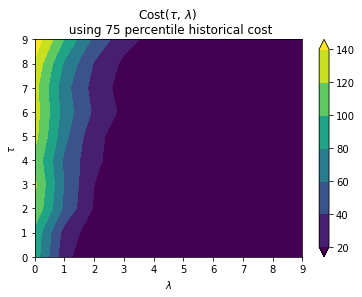

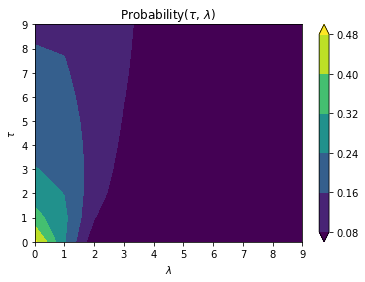

In [58]:
ax_cost = plt.figure().gca()
cs_cost = ax_cost.contourf(COST, extend='both')
ax_cost.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.colorbar(cs_cost)
# plt.xticks()
plt.xlabel('$\lambda$')
plt.ylabel('$\\tau$')
plt.title('Cost($\\tau$, $\lambda$) \n using 75 percentile historical cost')
plt.show()

# prob
ax_prob = plt.figure().gca()
cs_prob = ax_prob.contourf(PROB, extend='both')
ax_prob.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.colorbar(cs_prob)
plt.xlabel('$\lambda$')
plt.ylabel('$\\tau$')
plt.title('Probability($\\tau$, $\lambda$)')
plt.show()

In [31]:
obj = np.zeros((n_tau, n_lambd))
for tau in range(n_tau):
    for lambd in range(n_lambd):
        obj[tau, lambd] = PROB[tau, lambd] * PROFIT[0, lambd] - COST[tau, lambd]
tau_star, lambd_star = obj.argmax()//n_lambd, obj.argmax() % n_lambd
print(tau_star, lambd_star)

7 4


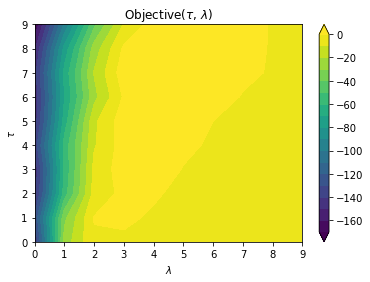

In [52]:
ax_obj = plt.figure().gca()
cs_obj = ax_obj.contourf(obj, levels=np.arange(obj.min()//10*10, (obj.max()//10+1)*10,10), extend='both')
ax_obj.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.colorbar(cs_obj)
plt.xlabel('$\lambda$')
plt.ylabel('$\\tau$')
plt.title('Objective($\\tau$, $\lambda$)')
plt.show()

In [55]:
pd.DataFrame(obj).sort_index(ascending=False)

,0,1,2,3,4,5,6,7,8,9
9,-169.296454,-98.500,-42.337751,-9.260235,4.280778,5.147905,3.313526,0.859555,-0.182966,-0.513504
8,-152.135878,-76.750,-25.557154,1.982146,8.535799,6.769156,2.904132,0.806824,-0.191803,-0.396639
7,-144.128143,-67.250,-19.295073,6.003970,9.535349,5.919771,2.167108,0.442034,-0.195130,-0.438242
6,-148.326510,-70.750,-23.078965,1.338402,6.883354,4.032434,0.935138,-0.126724,-0.477976,-0.381593
5,-146.314778,-65.500,-12.211436,5.528271,5.906738,2.393842,0.002972,-0.512543,-0.515800,-0.496638
4,-136.984863,-56.500,-11.047244,4.691065,3.676965,0.812476,-0.547944,-0.589077,-0.494906,-0.399760
3,-148.353901,-58.500,-7.054413,4.910896,2.178315,-0.168387,-0.448921,-0.393518,-0.324830,-0.300000
2,-145.260061,-55.250,-6.074353,2.603902,0.340367,-0.704042,-0.494527,-0.400000,-0.300000,-0.300000
1,-129.066844,-32.500,0.428915,0.541179,-0.377095,-0.300000,-0.300000,-0.200000,-0.200000,-0.200000
0,-141.993421,-26.125,-1.079605,-0.525000,-0.300000,-0.200000,-0.200000,-0.200000,-0.175000,-0.100000


In [59]:
pd.DataFrame(COST).sort_index(ascending=False)

,0,1,2,3,4,5,6,7,8,9
9,154.00,98.500,55.000,27.500,12.500,6.500,3.10,2.000,1.225,0.825
8,136.00,76.750,38.500,15.875,6.900,3.100,2.00,1.125,0.800,0.550
7,127.00,67.250,32.500,11.250,4.250,2.025,1.30,0.725,0.500,0.500
6,130.00,70.750,36.500,15.000,4.900,1.900,1.25,0.725,0.600,0.400
5,126.50,65.500,25.750,9.450,3.500,1.550,1.15,0.750,0.550,0.500
4,115.25,56.500,24.500,8.300,3.025,1.350,1.00,0.650,0.500,0.400
3,124.00,58.500,20.000,5.250,1.700,1.000,0.55,0.400,0.325,0.300
2,117.00,55.250,17.625,3.775,1.100,0.850,0.50,0.400,0.300,0.300
1,94.00,32.500,7.900,1.650,0.525,0.300,0.30,0.200,0.200,0.200
0,91.50,26.125,3.300,0.525,0.300,0.200,0.20,0.200,0.175,0.100


# backtest
- buy at ask / sell at bid
- payoff = ($p_0$ - $p_{\tau}$) - ($pc_{\lambda}$-$pc_{\lambda+1}$)

In [67]:
df['2015-01-21':'2015-01-21']

,close,prc_qtz,delta,maturity,d2m,delta_cell
date,,,,,,
2015-01-21,9319.71,9300.0,100.0,2015-01-21,0.0,1.0


In [65]:
df_tau = df.query(f'd2m=={tau_star}')

,close,prc_qtz,delta,maturity,d2m,delta_cell
date,,,,,,
2015-01-12,9178.30,9100.0,-100.0,2015-01-21,7.0,-1.0
2015-02-05,9512.05,9500.0,0.0,2015-02-24,7.0,0.0
2015-03-09,9562.98,9500.0,-100.0,2015-03-18,7.0,-1.0
2015-04-02,9600.32,9600.0,100.0,2015-04-15,7.0,1.0
2015-05-11,9663.72,9600.0,0.0,2015-05-20,7.0,0.0


In [76]:
df_call = pd.concat([
    get_all_txo_opt_price(
        date=row.Index.strftime('%Y.%m.%d'), 
        maturity=row.maturity.strftime('%Y%m'),
        right=cfg.RIGHT
    ) for row in df_tau.itertuples()])

In [77]:
df_call.head()

,date,maturity,strike,opt_price
0,2015-01-09,201501,7200.0,2030.0
1,2015-01-09,201501,7300.0,1930.0
2,2015-01-09,201501,7400.0,1830.0
3,2015-01-09,201501,7500.0,1730.0
4,2015-01-09,201501,7600.0,1630.0
